# Phase 1–4 Capability Showcase

This notebook demonstrates the evolving managed futures research stack across the first four development phases:

1. **Phase 1 – Data Foundations:** flexible loaders with a synthetic fallback so experiments stay reproducible.
2. **Phase 2 – Core Signals:** canonical trend styles (time-series momentum, moving average confirmation, breakout filters).
3. **Phase 3 – Risk & Portfolio Construction:** volatility targeting, sector caps, and contract-aware position sizing.
4. **Phase 4 – Execution & Evaluation:** a daily backtester with trading frictions plus reporting utilities and performance diagnostics.


## Environment setup
Install the project in editable mode so the notebook can import the `tf` package directly.

In [1]:
from pathlib import Path

repo_root = Path.cwd().resolve().parents[1]
%pip install -q -e {repo_root}

!pip install -q rich

Note: you may need to restart the kernel to use updated packages.


In [2]:
import sys
import pathlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

repo_root = pathlib.Path.cwd().resolve().parents[1]
src_path = repo_root / "src"
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

plt.style.use("ggplot")

from tf.data import load_prices_or_generate
from tf.signals import timeseries_momentum, price_vs_sma, channel_breakout
from tf.risk.vol import ewma_vol, rolling_volatility
from tf.portfolio.sizing import volatility_target_positions
from tf.engine.backtester import Backtester
from tf.eval.metrics import performance_summary


## Phase 1 – Data foundations
Leverage the data utilities to load a multi-asset universe. If market data are unavailable the loader automatically falls back to deterministic synthetic prices so results stay reproducible.

In [3]:
universe = [
    {"symbol": "ES", "sector": "Equities", "point_value": 50, "contract_step": 1},
    {"symbol": "NQ", "sector": "Equities", "point_value": 20, "contract_step": 1},
    {"symbol": "CL", "sector": "Energy", "point_value": 1000, "contract_step": 1},
    {"symbol": "GC", "sector": "Metals", "point_value": 100, "contract_step": 1},
]

prices = load_prices_or_generate(universe, start_date="2014-01-01", end_date="2019-12-31", seed=11)
prices.tail()


Ticker,ES,NQ,CL,GC
2019-12-25,3225.75,8729.50,61.110001,1499.099976
2019-12-26,3244.50,8804.25,61.680000,1509.300049
2019-12-27,3237.50,8783.25,61.720001,1513.800049
2019-12-30,3223.50,8733.75,61.680000,1514.500000
2019-12-31,3223.50,8733.75,61.680000,1514.500000


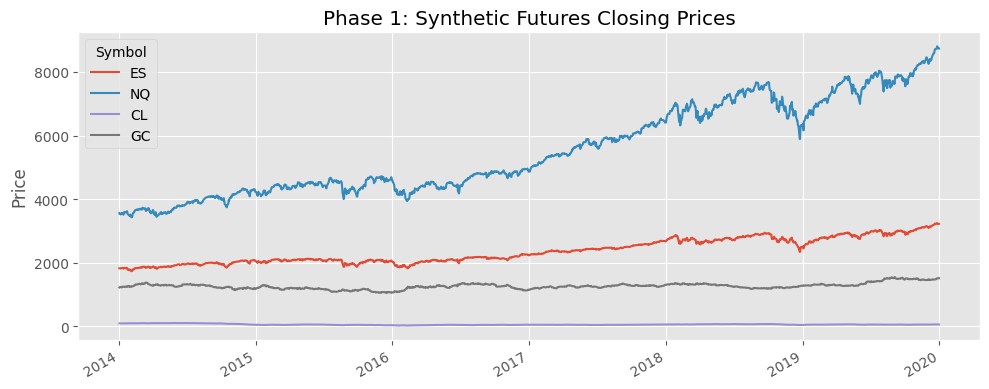

In [4]:
fig, ax = plt.subplots(figsize=(10, 4))
prices.plot(ax=ax)
ax.set_title("Phase 1: Synthetic Futures Closing Prices")
ax.set_ylabel("Price")
ax.legend(title="Symbol", loc="upper left")
plt.tight_layout()


## Phase 2 – Core signal library
Combine multiple momentum-style indicators to form a composite view of trend strength.

In [5]:
momentum = timeseries_momentum(prices, lookbacks=(63, 126, 189), skip_last_n=10)
moving_avg = price_vs_sma(prices, fast=50, slow=150)
breakout = channel_breakout(prices, window=80)

signals = {
    "momentum": momentum,
    "moving_average": moving_avg,
    "breakout": breakout,
}
combined_signals = sum(signals.values()) / len(signals)
combined_signals.tail()


Ticker,ES,NQ,CL,GC
2019-12-25,0.065510,0.070542,0.046750,0.004589
2019-12-26,0.065157,0.070365,0.044795,0.017023
2019-12-27,0.068400,0.072072,0.045669,0.030384
2019-12-30,0.066126,0.070259,0.048904,0.035613
2019-12-31,0.062661,0.067205,0.048979,0.036500


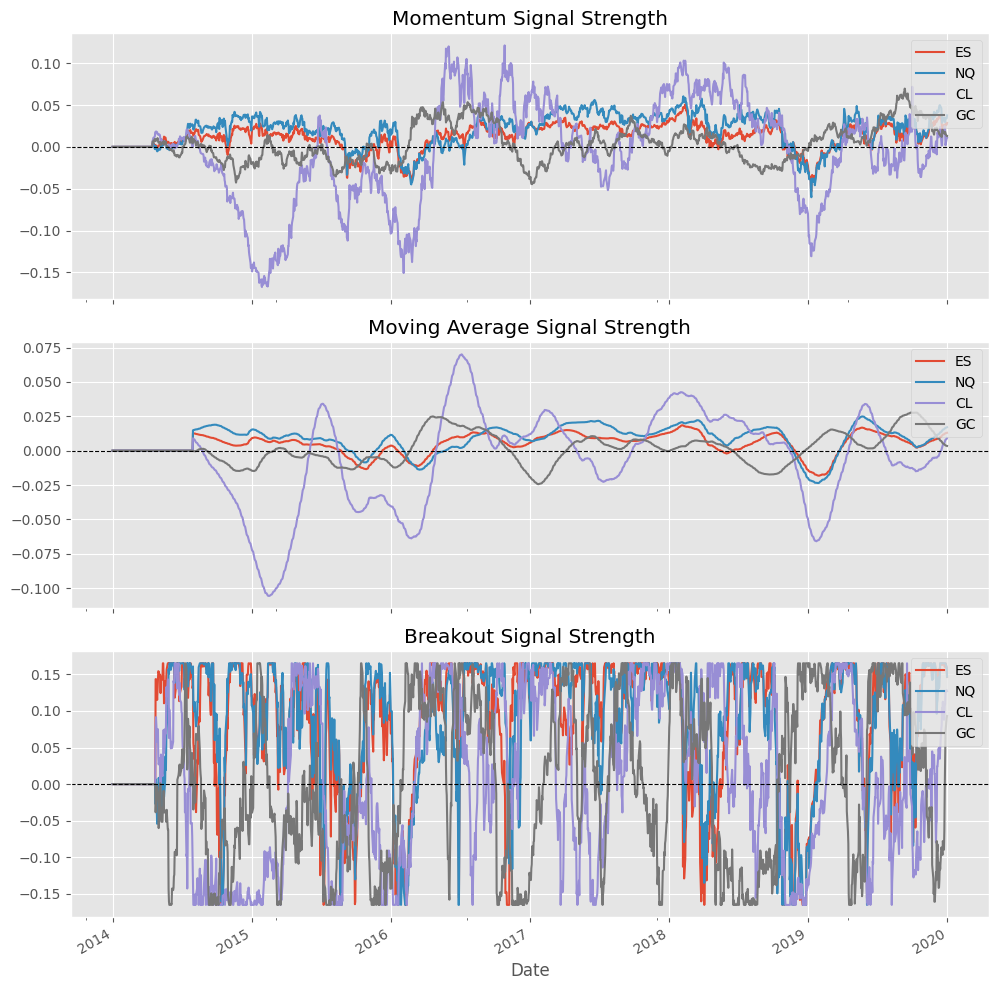

In [6]:
fig, axes = plt.subplots(len(signals), 1, figsize=(10, 10), sharex=True)
axes = np.atleast_1d(axes)
for ax, (name, signal_df) in zip(axes, signals.items()):
    signal_df.plot(ax=ax)
    ax.set_title(f"{name.replace('_', ' ').title()} Signal Strength")
    ax.axhline(0, color="black", linewidth=0.8, linestyle="--")
    ax.legend(loc="upper right")
axes[-1].set_xlabel("Date")
plt.tight_layout()


## Phase 3 – Risk and portfolio construction
Estimate volatility, enforce sector-level risk budgets, and translate signals into contract positions using the portfolio sizing toolkit.

In [7]:
returns = prices.pct_change().dropna()
ewma_volatility = ewma_vol(returns, lam=0.94, min_periods=20)
rolling_volatility_est = rolling_volatility(returns, window=63)

comparison = pd.concat({"EWMA": ewma_volatility["ES"], "Rolling": rolling_volatility_est["ES"]}, axis=1)
comparison.tail()


,EWMA,Rolling
2019-12-25,0.071498,0.096201
2019-12-26,0.071201,0.096341
2019-12-27,0.070694,0.091739
2019-12-30,0.072178,0.082267
2019-12-31,0.070137,0.080287


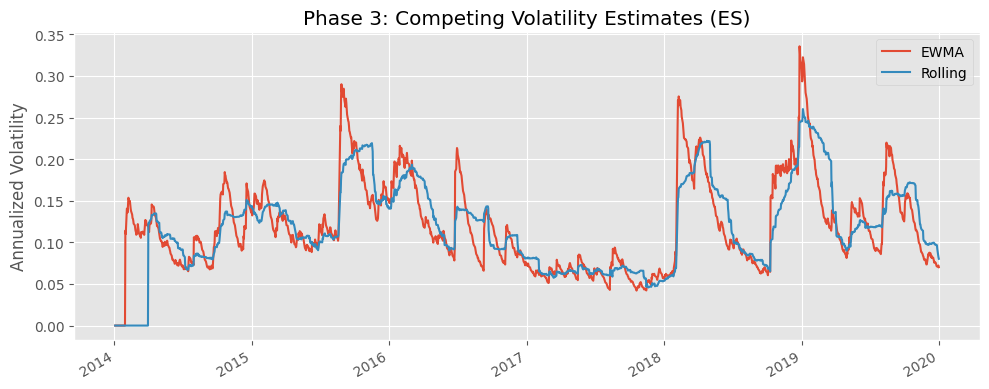

In [8]:
fig, ax = plt.subplots(figsize=(10, 4))
comparison.plot(ax=ax)
ax.set_title("Phase 3: Competing Volatility Estimates (ES)")
ax.set_ylabel("Annualized Volatility")
plt.tight_layout()


In [9]:
point_values = {item["symbol"]: item["point_value"] for item in universe}
sector_map = {item["symbol"]: item["sector"] for item in universe}
sector_caps = {"Equities": 0.45, "Energy": 0.35, "Metals": 0.30}
capital = 2_000_000.0

risk_target_contracts = volatility_target_positions(
    prices=prices,
    signals=combined_signals,
    point_values=point_values,
    capital=capital,
    target_portfolio_vol=0.15,
    gross_exposure_limit=3.0,
    sector_map=sector_map,
    sector_caps=sector_caps,
    contract_rounding=1,
    rebalance_threshold=0.0,
    risk_allocator="erc",
)
risk_target_contracts.tail()


Ticker,ES,NQ,CL,GC
2019-12-25,6.0,4.0,5.0,6.0
2019-12-26,6.0,4.0,5.0,6.0
2019-12-27,6.0,4.0,5.0,6.0
2019-12-30,6.0,4.0,5.0,6.0
2019-12-31,6.0,4.0,6.0,6.0


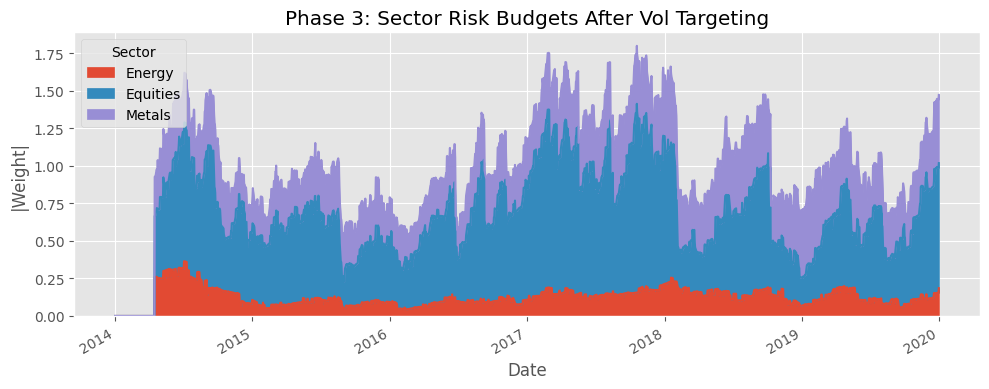

In [10]:
notional = risk_target_contracts.mul(prices, axis=0)
for symbol, pv in point_values.items():
    notional[symbol] *= float(pv)
weights = notional / capital

sector_allocations = weights.abs().rename(columns=sector_map).T.groupby(level=0).sum().T

fig, ax = plt.subplots(figsize=(10, 4))
sector_allocations.plot.area(ax=ax, stacked=True)
ax.set_title("Phase 3: Sector Risk Budgets After Vol Targeting")
ax.set_ylabel("|Weight|")
ax.set_xlabel("Date")
ax.legend(title="Sector", loc="upper left")
plt.tight_layout()


## Phase 4 – Execution loop and performance evaluation
Run the daily backtester with trading frictions, then visualize portfolio equity, drawdowns, turnover, and summary analytics.

In [11]:
cfg = {
    "backtest": {
        "start": "2014-01-01",
        "end": "2019-12-31",
        "results_dir": "results/notebooks",
        "starting_nav": capital,
    },
    "signals": {
        "momentum": {"lookbacks": [63, 126, 189], "skip_last_n": 10},
    },
    "risk": {
        "target_portfolio_vol": 0.15,
        "gross_exposure_limit": 3.0,
        "sector_caps": sector_caps,
        "risk_allocator": "erc",
        "rebalance_threshold": 0.5,
        "vol_model": "ewma",
        "vol_lookback": 63,
        "ewma_lambda": 0.94,
        "min_vol_periods": 20,
    },
    "execution": {
        "commission_per_contract": 2.0,
        "tick_value": 12.5,
        "min_slippage_ticks": 0.25,
        "impact": {"k": 0.05, "alpha": 0.5},
        "adv_limit_pct": 0.15,
        "default_adv_contracts": 5_000,
        "roll_schedule": {},
    },
}

backtester = Backtester(prices, universe, cfg)
results = backtester.run()
results.nav.tail()


2019-12-25    2.275898e+06
2019-12-26    2.296468e+06
2019-12-27    2.295588e+06
2019-12-30    2.287648e+06
2019-12-31    2.287648e+06
Freq: C, dtype: float64

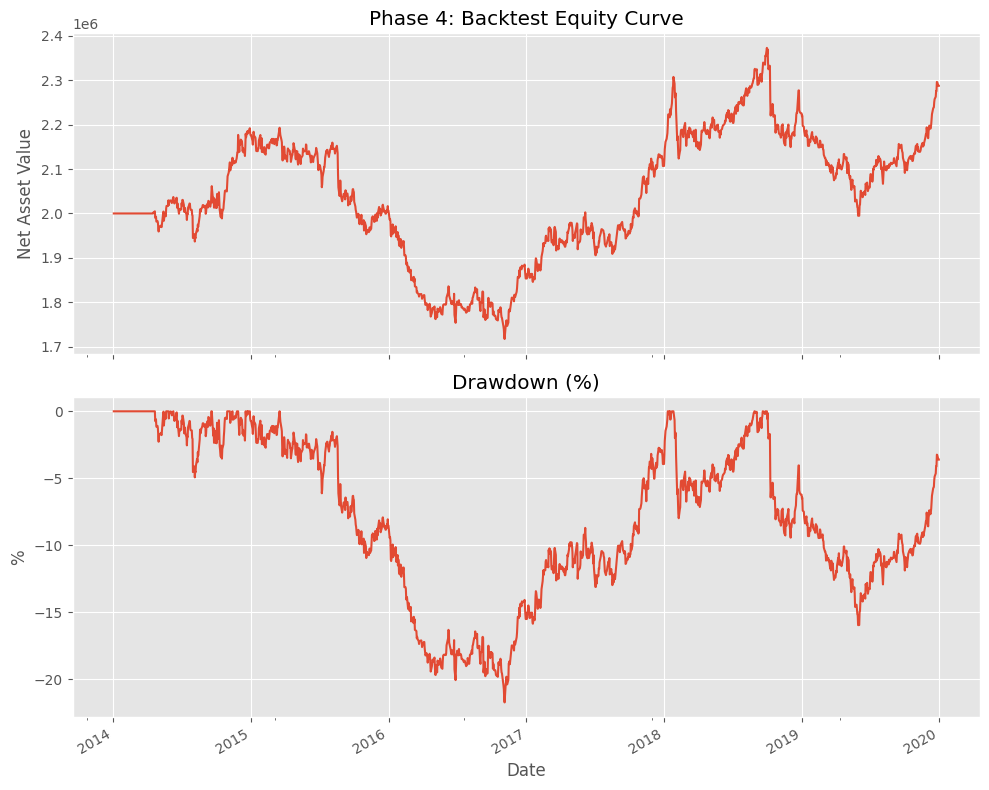

In [12]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
results.nav.plot(ax=axes[0])
axes[0].set_title("Phase 4: Backtest Equity Curve")
axes[0].set_ylabel("Net Asset Value")

drawdown = results.nav / results.nav.cummax() - 1
(100 * drawdown).plot(ax=axes[1])
axes[1].set_title("Drawdown (%)")
axes[1].set_ylabel("%")
axes[1].set_xlabel("Date")
plt.tight_layout()


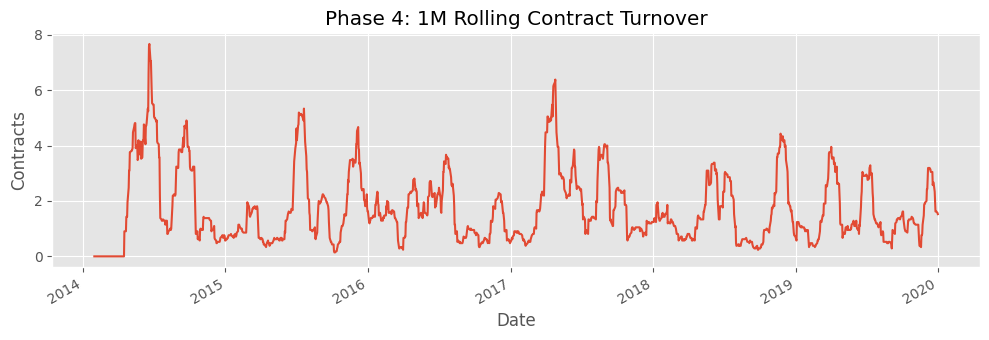

In [13]:
turnover = results.positions.diff().abs().sum(axis=1)
fig, ax = plt.subplots(figsize=(10, 3.5))
turnover.rolling(window=21).mean().plot(ax=ax)
ax.set_title("Phase 4: 1M Rolling Contract Turnover")
ax.set_ylabel("Contracts")
ax.set_xlabel("Date")
plt.tight_layout()


In [14]:
summary = pd.Series(performance_summary(results.nav))
costs_cum = results.costs.cumsum()

summary, costs_cum.tail()


(CAGR      0.021902
 Vol       0.086651
 Sharpe    0.293447
 MaxDD    -0.217098
 dtype: float64,
               trading  roll      total
 2019-12-25  13642.750   0.0  13642.750
 2019-12-26  13647.875   0.0  13647.875
 2019-12-27  13647.875   0.0  13647.875
 2019-12-30  13647.875   0.0  13647.875
 2019-12-31  13647.875   0.0  13647.875)

In [ ]:
results.trades.head()

,ts,symbol,qty,price,notional,slippage,commission,cost,reason,order_id,partial
0,2014-04-17,ES,5.0,1858.000000,464500.000000,15.625,10.0,25.625,rebalance,1,False
1,2014-04-17,NQ,5.0,3523.250000,352325.000000,15.625,10.0,25.625,rebalance,2,False
2,2014-04-17,CL,5.0,104.300003,521500.015259,15.625,10.0,25.625,rebalance,3,False
3,2014-04-17,GC,4.0,1293.400024,517360.009766,12.500,8.0,20.500,rebalance,4,False
4,2014-04-22,ES,1.0,1874.000000,93700.000000,3.125,2.0,5.125,rebalance,5,False
